In [117]:
import pandas as pd
from glob import glob
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
import rdflib
import re
from tqdm import tqdm
import numpy as np

## Analyse training

In [35]:
files = glob("experiments/training/*.json")
df = None

for f in files:
  f_data = json.load(open(f))
  series = pd.Series()

  model, degree, _, _ = f.split(".")
  series["degree"] = int(degree) + 1
  series["model"] = model

  #series["train_losses"] = f_data["train_losses"]
  #series["train_loss"] = f_data["train_losses"][-1] if len(series["train_losses"]) > 0 else -1

  #series["test_losses"] = f_data["test_losses"]
  #series["test_loss"] = f_data["test_losses"][-1] if len(series["test_losses"]) > 0 else -1

  for rel, val in f_data["relationship_weights"].items():
    series[rel] = val

  metrics = {k: [m[k] for m in f_data["metrics"]] for k in f_data["metrics"][0].keys()}
  #series["metrics"] = metrics

  for k, v in metrics.items():
    series[k] = max(v) #[-1]

  series = series.to_frame().T
  if df is None:
    df = series
  else:
    df = pd.concat([df, series])

df.columns = [c.replace("@None", "") for c in df.columns]

In [36]:
x_labels = ["DNN", "Learned", "freq", "freq$^{-1}$", 1]
df_model = ['experiments/training/dnn', 'experiments/training/fit', 'experiments/training/frequency', 'experiments/training/inverse-frequency', 'experiments/training/uniform']

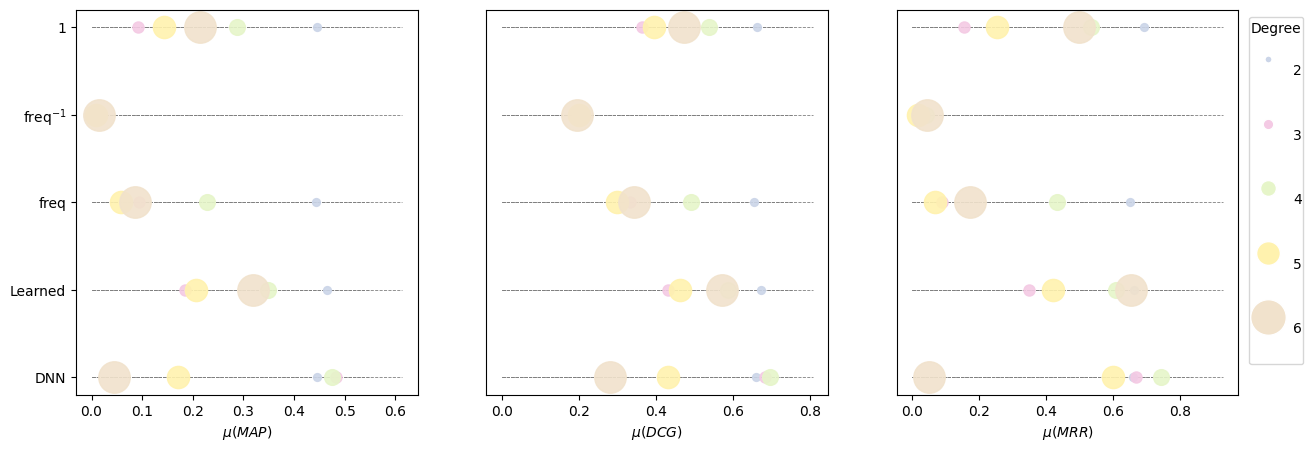

In [39]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
cmap = mpl.colormaps["Pastel2"]
x_axis = list(range(len(x_labels)))
degrees = sorted(df.degree.unique())

for model, x in zip(df_model, x_axis):
  model_df = df[df.model == model]
  for degree in degrees:
    for idx, measure in enumerate(["MAP", "DCG", "MRR"]):
      val = model_df[model_df.degree == degree][measure].mean()
      ax[idx].hlines(x, 0, df[df.degree == degree][measure].max(), colors="grey", linestyles="dashed", zorder=-1, linewidths=0.6)
      ax[idx].scatter(val, x, color=cmap(degree), s=2 ** (degree + 3), alpha=0.9)
      ax[idx].set_xlabel(f"$\mu({measure})$")

      if idx == 0:
        ax[idx].set_yticks(x_axis, x_labels)
      else:
        ax[idx].set_yticks([])

legend_elements = [
  mpl.lines.Line2D([0], [0], marker='o', color='w', label=degree, markerfacecolor=cmap(degree), markersize=1.5 ** (degree + 2))
  for degree in degrees
]
ax[-1].legend(handles=legend_elements, bbox_to_anchor=(1.01, 1, 0.2, 0), loc='upper left', mode="expand", title="Degree", handleheight=6)

fig.savefig('figures/degree_performance.png', dpi=300, bbox_inches="tight")

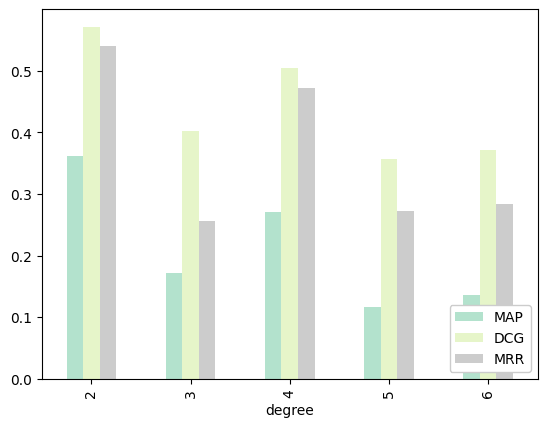

In [40]:
ax = df.groupby(["degree"])[["MAP", "DCG", "MRR"]].mean().plot.bar(cmap="Pastel2")
ax.legend(loc='lower right', framealpha=1)
fig = ax.get_figure()
fig.savefig('figures/degree_plot.png', dpi=300, bbox_inches="tight")

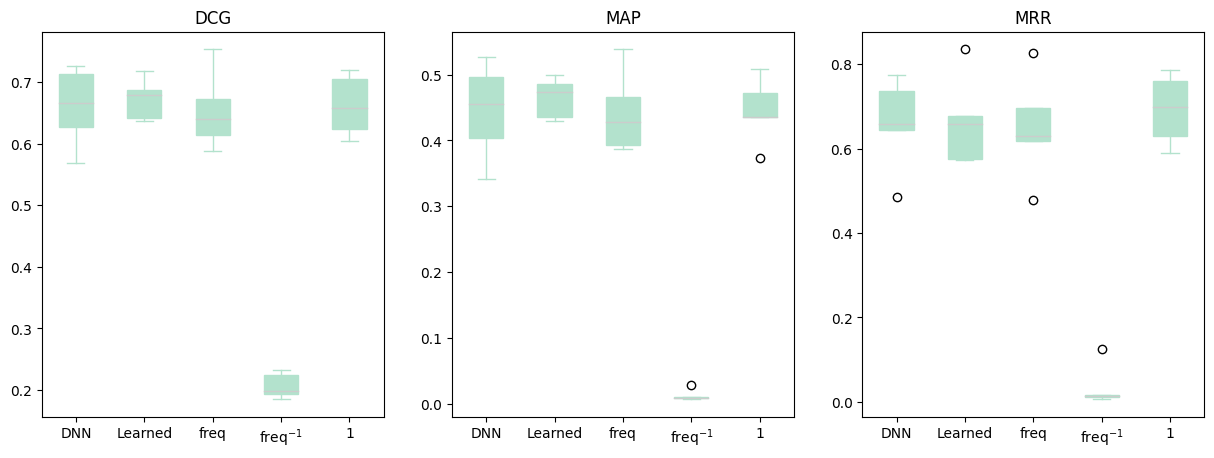

In [41]:
axs = df[df.degree == 2].plot.box(column=["MAP", "DCG", "MRR"], cmap="Pastel2", by="model", figsize=(15, 5), patch_artist=True)

for ax in axs:
  ax.set_xticklabels(["DNN", "Learned", "freq", "freq$^{-1}$", 1])

fig.savefig('figures/degree_plot.png', dpi=300, bbox_inches="tight")

In [107]:
print(df[df.degree == 2].sort_values(["MAP", "DCG", "MRR"], ascending=False).groupby("model")[["MAP", "DCG", "MRR"]].agg(lambda x: f"${x.mean():1.2f} \pm {x.std():1.2f}$").to_latex())

\begin{tabular}{llll}
\toprule
 & MAP & DCG & MRR \\
model &  &  &  \\
\midrule
experiments/training/dnn & $0.44 \pm 0.07$ & $0.66 \pm 0.06$ & $0.66 \pm 0.11$ \\
experiments/training/fit & $0.46 \pm 0.03$ & $0.67 \pm 0.03$ & $0.66 \pm 0.11$ \\
experiments/training/frequency & $0.44 \pm 0.06$ & $0.65 \pm 0.06$ & $0.65 \pm 0.13$ \\
experiments/training/inverse-frequency & $0.01 \pm 0.01$ & $0.21 \pm 0.02$ & $0.03 \pm 0.05$ \\
experiments/training/uniform & $0.45 \pm 0.05$ & $0.66 \pm 0.05$ & $0.69 \pm 0.08$ \\
\bottomrule
\end{tabular}



In [109]:
columns = [
  'https://w3id.org/polifonia/ontology/relationship/hasAcquaintance',
  'https://w3id.org/polifonia/ontology/relationship/hasPupil',
  'https://w3id.org/polifonia/ontology/relationship/hasBandmate',
  'https://w3id.org/polifonia/ontology/relationship/hasFriend',
  'https://w3id.org/polifonia/ontology/relationship/hasMentor',
  'MRR',
  'MAP', 
  'DCG'
]

In [116]:
print(df[(df.model == "experiments/training/fit")][columns].corr().loc[["MRR", "MAP", "DCG"], columns[:-3]].rename(lambda c: c.split("/")[-1], axis=1).to_latex())

\begin{tabular}{lrrrrr}
\toprule
 & hasAcquaintance & hasPupil & hasBandmate & hasFriend & hasMentor \\
\midrule
MRR & -0.409834 & 0.266801 & 0.510103 & 0.635146 & 0.446102 \\
MAP & -0.469046 & 0.232629 & 0.226032 & 0.427203 & 0.250137 \\
DCG & -0.481689 & 0.241699 & 0.312996 & 0.512511 & 0.294137 \\
\bottomrule
\end{tabular}



In [122]:
small_df = df[(df.model == "experiments/training/fit") & (df.degree == 2)].groupby(["degree", "model"]).agg(["median", "mean", "min", "max"])[columns[:-3]].T.reset_index()
small_df.columns = small_df.columns.get_level_values(0)
small_df = small_df.pivot(columns="level_1", index="level_0", values=2).rename(lambda c: c.split("/")[-1], axis=0)
print(small_df.to_latex())

\begin{tabular}{lllll}
\toprule
level_1 & max & mean & median & min \\
level_0 &  &  &  &  \\
\midrule
hasAcquaintance & -0.330795 & -0.362327 & -0.368286 & -0.379562 \\
hasBandmate & 0.714585 & 0.701627 & 0.699995 & 0.694081 \\
hasFriend & 0.740409 & 0.726573 & 0.725206 & 0.716178 \\
hasMentor & 0.775875 & 0.741567 & 0.735870 & 0.722411 \\
hasPupil & 0.749730 & 0.732634 & 0.731428 & 0.718561 \\
\bottomrule
\end{tabular}



## Analyse inference

In [123]:
# ground truth
gt = rdflib.Graph().parse("resources/meetups_with_allmusic_influence.ttl")
influece_p = rdflib.URIRef("https://w3id.org/polifonia/ontology/relationship/admires")
gt_influences = set([f"{source}_{target}" for source, _, target in gt.triples((None, influece_p, None))])

data = []
inf_graphs = glob("experiments/inference/*.ttl")

In [124]:
for inf_graph in tqdm(inf_graphs):
  inf_data = dict()
  inf_data["threshold"] = float(re.findall(pattern="(\d\.\d+)", string=inf_graph)[0])
  
  pred = rdflib.Graph().parse(inf_graph)
  pred_influences = set([f"{source}_{target}" for source, _, target in pred.triples((None, influece_p, None))])

  inf_data["recall"] = len(pred_influences.intersection(gt_influences)) / len(gt_influences)
  inf_data["precision"] = len(pred_influences.intersection(gt_influences)) / len(pred_influences)

  data.append(inf_data)

df = pd.DataFrame.from_dict(data)
df.to_csv("experiments/inference/meetups_results.csv")

 45%|████▌     | 9/20 [10:49<13:14, 72.22s/it] 


IndexError: list index out of range

In [129]:
df = pd.DataFrame.from_dict(data)

In [130]:
df

,threshold,precision,recall
0,0.30,0.222734,0.001744
1,0.45,0.177027,0.002794
2,0.95,0.107949,0.007246
3,0.85,0.117091,0.006597
4,0.10,0.351351,0.000282
5,0.20,0.268124,0.001056
6,0.60,0.150397,0.004575
7,0.65,0.143800,0.005012
8,0.40,0.189269,0.002569
